<a href="https://colab.research.google.com/github/callmesora/AnomalyDetection-Cookbook/blob/main/Anomaly_Detection_Rasp_LSTM_AutoEncoder_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Necessary libraries

import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout , Dense, RepeatVector, TimeDistributed
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from keras.models import Model 
import seaborn as sns 

In [ ]:

df = pd.read_csv('./out.csv')  

In [ ]:
df.head()

,time,x,y,z
0,0.0000,0.08594,-0.53125,0.57031
1,0.0005,0.09375,-0.50781,0.60938
2,0.0010,0.10938,-0.56250,0.55469
3,0.0015,0.12500,-0.56250,0.61719
4,0.0020,0.14062,-0.61719,0.50781


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   time    120000 non-null  float64
 1    x      120000 non-null  float64
 2    y      120000 non-null  float64
 3    z      120000 non-null  float64
dtypes: float64(4)
memory usage: 3.7 MB


In [ ]:
df.rename(columns={' x': 'x', ' y': 'y', ' z':'z'}, inplace=True) #fixing spacing
df.head()

,time,x,y,z
0,0.0000,0.08594,-0.53125,0.57031
1,0.0005,0.09375,-0.50781,0.60938
2,0.0010,0.10938,-0.56250,0.55469
3,0.0015,0.12500,-0.56250,0.61719
4,0.0020,0.14062,-0.61719,0.50781


In [ ]:
# Convert Date time to date format # We need to change the script to record a timestamp
#df['time'] = pd.to_datetime(df['time'])

In [ ]:
#df.head() # Note to self, we need to re-fractor the code to register the correct timestamp

In [ ]:
df.columns

In [ ]:
fig, axs = plt.subplots(nrows=3)

sns.lineplot(x=df['time'],y=df['x'],  ax=axs[0], color='blue', label='x')
sns.lineplot(x=df['time'],y=df['y'],  ax=axs[1], color='red' ,   label='y')
sns.lineplot(x=df['time'],y=df['z'],  ax=axs[2], color ='green', label='z')
plt.legend() 

In [ ]:
# Select train test split, I'm gonna split it where I seem fit 
train, test = df.loc[df['time'] <= 30] , df.loc[df['time'] > 30]

print("Start date is: ", df['time'].min())
print("End date is: ", df['time'].max())

Start date is:  0.0
End date is:  59.9995


In [ ]:
test.describe()

,time,x,y,z
count,59999.000000,59999.000000,59999.000000,59999.000000
mean,45.000000,0.259667,-0.686824,-0.421683
std,8.660182,0.220879,0.249829,0.464451
min,30.000500,-8.085940,-7.007810,-4.070310
25%,37.500250,0.156250,-0.828120,-0.804690
50%,45.000000,0.273440,-0.710940,-0.445310
75%,52.499750,0.367190,-0.546880,-0.078120
max,59.999500,5.117190,8.570310,6.000000


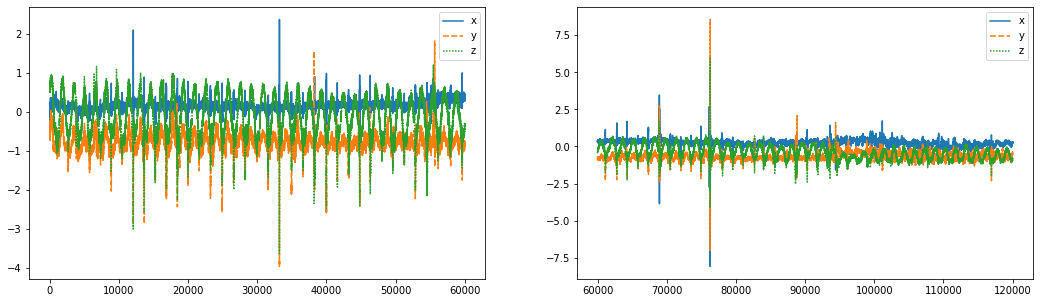

In [ ]:
fig, axs = plt.subplots(ncols=2,figsize=(18,5))
sns.lineplot(data=train.drop('time',axis=1), ax=axs[0])
sns.lineplot(data=test.drop('time',axis=1), ax=axs[1])

In [ ]:
# Apply transform
# Maybe since there is an anomaly in the dataset we could try to not scale, since they are all inherited in the same scale since its the same device
# Scale and normalize 

scaling = False 
if scaling == True:
  scaler = StandardScaler()
  scaler = scaler.fit(train[['x','y','z']])
  train[['x','y','z']] = scaler.transform(train[['x','y','z']])
  test[['x','y','z']]= scaler.transform(test[['x','y','z']])


In [ ]:
test.head()

,time,x,y,z
60001,30.0005,0.35156,-0.82031,-0.39844
60002,30.0010,0.35938,-0.87500,-0.42188
60003,30.0015,0.28125,-0.75000,-0.35156
60004,30.0020,0.31250,-0.77344,-0.34375
60005,30.0025,0.35938,-0.80469,-0.32812


In [ ]:
seq_size = 3000 # Number of time steps to look back 
# Larger sequences may improove forcasting 

In [ ]:
# Convert the DataFrame into a numpy array of sequence lenght
def to_sequences(x,y,seq_size = 1):
  x_values = []
  y_values = [] 

  for i in range(len(x)-seq_size):
    x_values.append(x.iloc[i:(i+seq_size)].values) # collect seq_size numbers
    y_values.append(y.iloc[i+seq_size]) # Collect the next number after the sequence

  return np.array(x_values), np.array(y_values) 


In [ ]:
X_train, y_train = to_sequences(train[['x']],train[['x']],seq_size) #I'm only using one acelerometer line at the time not enough ram for 3 
X_test, y_test = to_sequences(test[['x']],test[['x']],seq_size)

In [ ]:
X_train.shape

(57001, 3000, 1)

In [ ]:
y_train.shape

(57001, 1)

In [ ]:
X_test.shape

(56999, 3000, 1)

In [ ]:
# Define Sequence
model = Sequential([LSTM(64,input_shape = (seq_size,1)),
                   Dropout(rate=0.2),
                   RepeatVector(seq_size),
                    LSTM(64,return_sequences=True),
                    Dropout(rate=0.2),
                    TimeDistributed(Dense(1)),
                    ])

In [ ]:
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 3000, 64)         0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 3000, 64)          33024     
                                                                 
 dropout_1 (Dropout)         (None, 3000, 64)          0         
                                                                 
 time_distributed (TimeDistr  (None, 3000, 1)          65        
 ibuted)                                                

In [ ]:
history = model.fit(X_train,y_train, epochs = 5, batch_size = 64, validation_split = 0.1, verbose = 1)

Epoch 1/5
347/347 [==============================] - 76s 196ms/step - loss: 0.0383 - val_loss: 0.0358
Epoch 2/5
347/347 [==============================] - 66s 191ms/step - loss: 0.0355 - val_loss: 0.0354
Epoch 3/5
347/347 [==============================] - 65s 187ms/step - loss: 0.0353 - val_loss: 0.0355
Epoch 4/5
347/347 [==============================] - 65s 186ms/step - loss: 0.0351 - val_loss: 0.0353
Epoch 5/5
347/347 [==============================] - 65s 186ms/step - loss: 0.0349 - val_loss: 0.0353


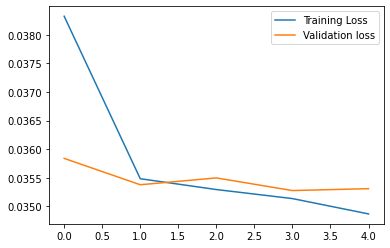

In [ ]:

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation loss')
plt.legend()

In [ ]:
reconst_pred = model.predict(X_train)

In [ ]:
from sklearn.metrics import mean_absolute_error , mean_squared_error
mae = mean_absolute_error(X_train.reshape(X_train.shape[0],seq_size),reconst_pred.reshape(X_train.shape[0],seq_size))
rmse = np.sqrt(mean_squared_error(X_train.reshape(X_train.shape[0],seq_size),reconst_pred.reshape(X_train.shape[0],seq_size)))

In [ ]:
mae,rmse

(0.1115613275380059, 0.1585247092747831)

In [ ]:
trainMAE = np.mean(np.abs(reconst_pred -X_train), axis=1)


In [ ]:
X_test

array([], dtype=float64)

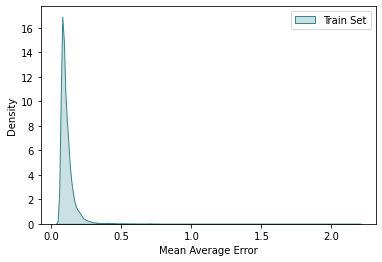

In [ ]:
# Plot Density Distribution of Mae
sns.kdeplot(data=trainMAE,fill=True, palette="crest",label='Train Set') # KDE PLOT
plt.xlabel('Mean Average Error')
plt.legend()

In [ ]:
# Plot Density Distribution of test set
test_reconst_pred = model.predict(X_test)
mae = mean_absolute_error(X_test.reshape(X_test.shape[0],seq_size),test_reconst_pred.reshape(X_test.shape[0],seq_size))
rmse = np.sqrt(mean_squared_error(X_test.reshape(X_test.shape[0],seq_size),test_reconst_pred.reshape(X_test.shape[0],seq_size)))

In [ ]:
mae,rmse

(0.17240405390315483, 0.270397071096618)

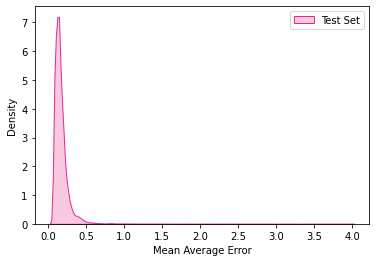

In [ ]:
testMAE = np.mean(np.abs(test_reconst_pred -X_test), axis=1)
# Plot Density Distribution of Mae of test dataset 
sns.kdeplot(data=testMAE,fill=True, palette="Dark2_r",label='Test Set',common_norm=True) # KDE PLOT
#sns.histplot(data=testMAE,fill=True, palette="Dark2_r",label='Box',bins=30)
plt.xlabel('Mean Average Error')
plt.legend()

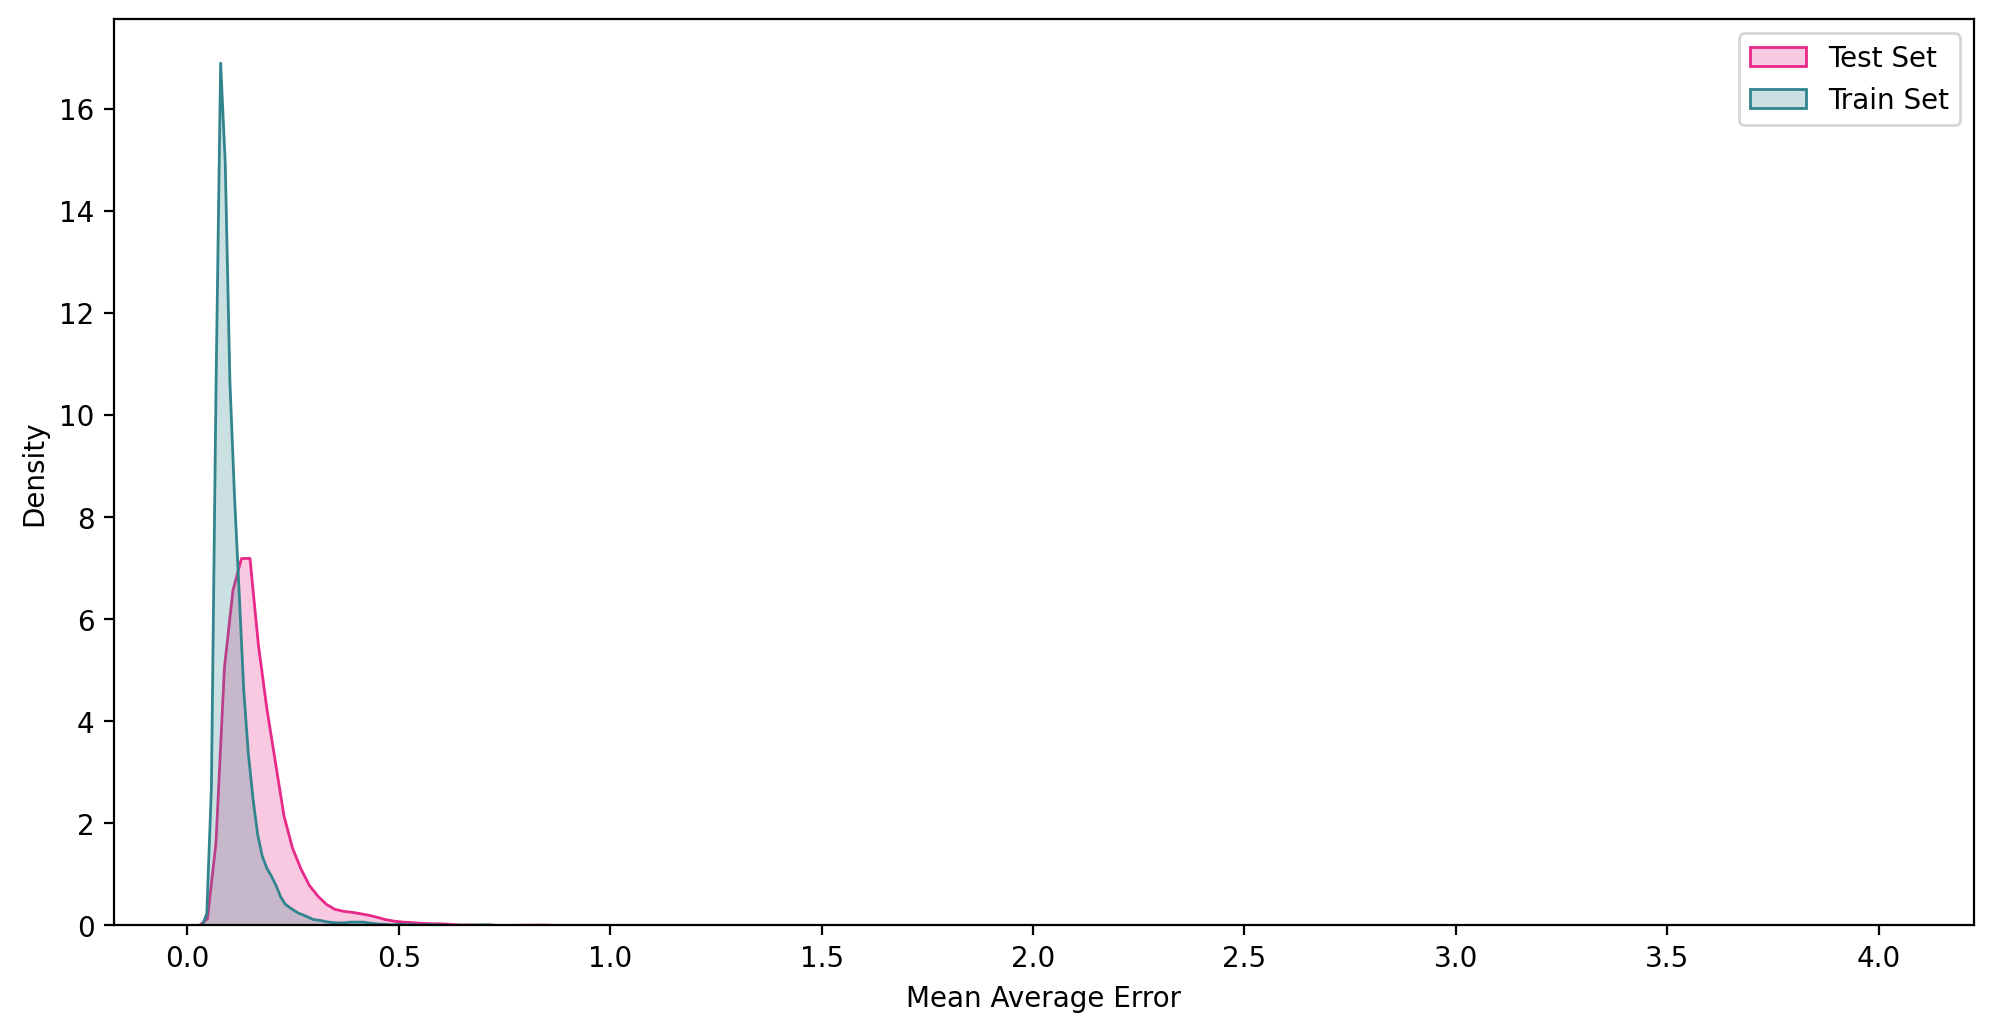

In [ ]:
plt.figure(figsize=(12,6),dpi=200)
sns.kdeplot(data=testMAE,fill=True, palette="Dark2_r",label='Test Set',bw_adjust=1) # KDE PLOT , change the bw_ajust
sns.kdeplot(data=trainMAE,fill=True, palette="crest",label='Train Set') # KDE PLOT
plt.xlabel('Mean Average Error')
plt.legend()

In [ ]:
# Set Threshold
max_trainMAE = 1.5

In [ ]:
#Capture all details in a DataFrame for easy plotting
anomaly_df = pd.DataFrame(test[seq_size:])
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
anomaly_df['x'] = test[seq_size:]['x']

In [ ]:
anomaly_df

,time,x,y,z,testMAE,max_trainMAE,anomaly
63001,31.5005,0.36719,-0.89844,-0.55469,0.070733,1.5,False
63002,31.5010,0.42969,-0.86719,-0.60938,0.069091,1.5,False
63003,31.5015,0.35156,-0.88281,-0.53125,0.070576,1.5,False
63004,31.5020,0.35938,-0.90625,-0.63281,0.069527,1.5,False
63005,31.5025,0.39844,-0.88281,-0.59375,0.068952,1.5,False
...,...,...,...,...,...,...,...
119995,59.9975,0.26562,-0.45312,-0.81250,0.110387,1.5,False
119996,59.9980,0.25000,-0.42188,-0.85938,0.113724,1.5,False
119997,59.9985,0.32031,-0.44531,-0.89844,0.113218,1.5,False
119998,59.9990,0.26562,-0.41406,-0.82031,0.127186,1.5,False


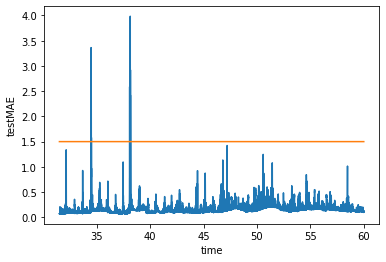

In [ ]:
#Plot testMAE vs max_trainMAE
sns.lineplot(x=anomaly_df['time'], y=anomaly_df['testMAE'])
sns.lineplot(x=anomaly_df['time'], y=anomaly_df['max_trainMAE'])

In [ ]:
#anomaly_df['Close_unNorm']= scaler.inverse_transform(anomaly_df[['Close']])
anomalies = anomaly_df.loc[anomaly_df['anomaly']==True]

In [ ]:
anomaly_df['anomaly'].value_counts() #only anomalies?

False    56938
True        61
Name: anomaly, dtype: int64

In [ ]:
len(anomaly_df), len(anomalies)

(56999, 61)

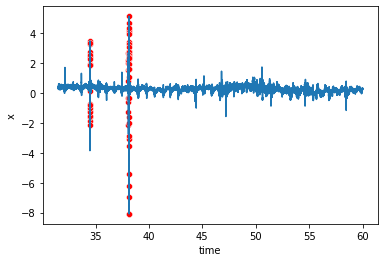

In [ ]:
#Plot anomalies

sns.lineplot(x=anomaly_df['time'], y=anomaly_df['x'])
sns.scatterplot(x=anomalies['time'], y=anomalies['x'], color='r')

In [ ]:
def plot_anomalies(X,mae_treshold):
  test_reconst_pred = model.predict(X,verbose=1)
  testMAE = np.mean(np.abs(test_reconst_pred -X_test), axis=1)
  max_trainMAE = mae_treshold
  #Capture all details in a DataFrame for easy plotting
  anomaly_df = pd.DataFrame(test[seq_size:])
  anomaly_df['testMAE'] = testMAE
  anomaly_df['max_trainMAE'] = max_trainMAE
  anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
  anomaly_df['x'] = test[seq_size:]['x']
  #Plot testMAE vs max_trainMAE
  sns.lineplot(x=anomaly_df['time'], y=anomaly_df['testMAE'])
  sns.lineplot(x=anomaly_df['time'], y=anomaly_df['max_trainMAE'])




In [ ]:
#plot_anomalies(X_train,1.5)

## Trying the same neural networked trained on X to predict on Y and **Z**

In [ ]:
X_train, y_train = to_sequences(train[['y']],train[['y']],seq_size) #I'm only using one acelerometer line at the time not enough ram for 3 
X_test, y_test = to_sequences(test[['y']],test[['y']],seq_size)

# Set Threshold
max_trainMAE = 1.5


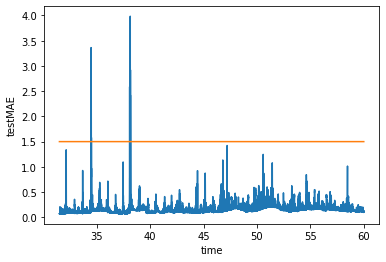

In [ ]:
# Calculate error
test_reconst_pred = model.predict(X_test)


In [ ]:
#Capture all details in a DataFrame for easy plotting
testMAE = np.mean(np.abs(test_reconst_pred -X_test), axis=1)
anomaly_df = pd.DataFrame(test[seq_size:])
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
anomaly_df['x'] = test[seq_size:]['y']

#Plot testMAE vs max_trainMAE
sns.lineplot(x=anomaly_df['time'], y=anomaly_df['testMAE'])
sns.lineplot(x=anomaly_df['time'], y=anomaly_df['max_trainMAE'])

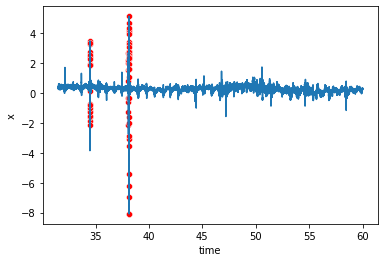

In [ ]:
anomalies = anomaly_df.loc[anomaly_df['anomaly']==True]
anomaly_df['anomaly'].value_counts() #only anomalies?


sns.lineplot(x=anomaly_df['time'], y=anomaly_df['y'],label=)
sns.scatterplot(x=anomalies['time'], y=anomalies['y'], color='r')

**Trying MultiVariabelAutoencoder** This one uses only the previous measure to determine if its an anomalie (it runs much faster)

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
#from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline


from numpy.random import seed
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

In [ ]:
# Different approach
df = pd.read_csv('./out.csv')  
df.head()

,time,x,y,z
0,0.0000,0.08594,-0.53125,0.57031
1,0.0005,0.09375,-0.50781,0.60938
2,0.0010,0.10938,-0.56250,0.55469
3,0.0015,0.12500,-0.56250,0.61719
4,0.0020,0.14062,-0.61719,0.50781


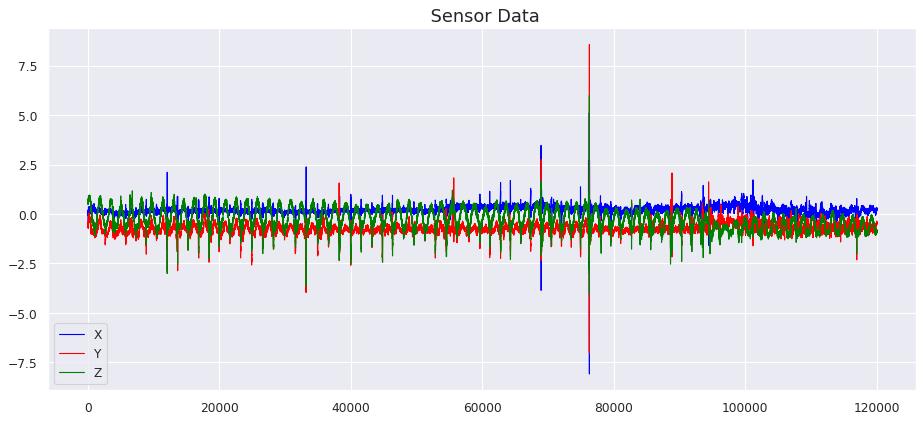

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(df[' x'], label='X', color='blue', animated = True, linewidth=1)
ax.plot(df[' y'], label='Y', color='red', animated = True, linewidth=1)
ax.plot(df[' z'], label='Z', color='green', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title(' Sensor Data', fontsize=16)
plt.show()

In [ ]:
# Select train test split, I'm gonna split it where I seem fit 
train, test = df.loc[df['time'] <= 30] , df.loc[df['time'] > 30]

print("Start date is: ", df['time'].min())
print("End date is: ", df['time'].max())

Start date is:  0.0
End date is:  59.9995


In [ ]:
# transforming data from the time domain to the frequency domain using fast Fourier transform
train_fft = np.fft.fft(train.drop('time',axis=1))
test_fft = np.fft.fft(test.drop('time',axis=1))

In [ ]:
test_fft.shape

(59999, 3)

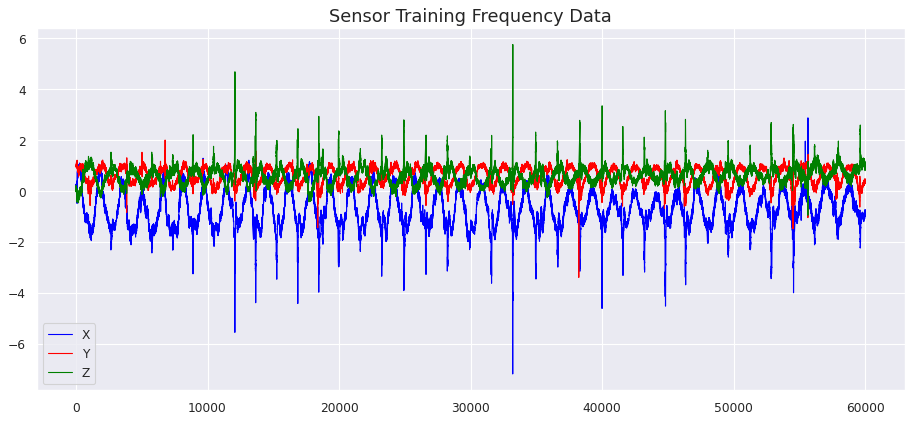

In [ ]:
# frequencies of the healthy sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft[:,0].real, label='X', color='blue', animated = True, linewidth=1)
ax.plot(train_fft[:,1].imag, label='Y', color='red', animated = True, linewidth=1)
ax.plot(train_fft[:,2].real, label='Z', color='green', animated = True, linewidth=1)

plt.legend(loc='lower left')
ax.set_title('Sensor Training Frequency Data', fontsize=16)
plt.show()

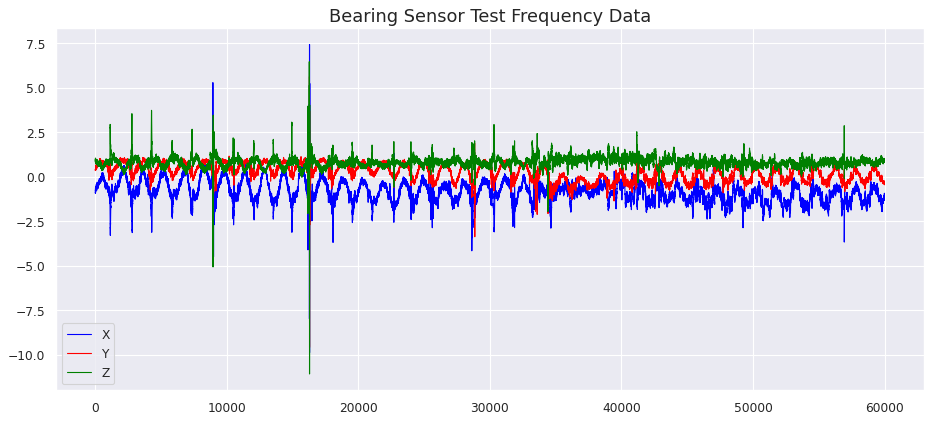

In [ ]:
# frequencies of the test set with the anomaly sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_fft[:,0].real, label='X', color='blue', animated = True, linewidth=1)
ax.plot(test_fft[:,1].imag, label='Y', color='red', animated = True, linewidth=1)
ax.plot(test_fft[:,2].real, label='Z', color='green', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Test Frequency Data', fontsize=16)
plt.show()

In [ ]:
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train.drop('time',axis=1))
X_test = scaler.transform(test.drop('time',axis=1))
scaler_filename = "scaler_data"

In [ ]:
X_train.shape

(60001, 3)

In [ ]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (60001, 1, 3)
Test data shape: (59999, 1, 3)


In [ ]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 3)]            0         
                                                                 
 lstm_8 (LSTM)               (None, 1, 16)             1280      
                                                                 
 lstm_9 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector_2 (RepeatVect  (None, 1, 4)             0         
 or)                                                             
                                                                 
 lstm_10 (LSTM)              (None, 1, 4)              144       
                                                                 
 lstm_11 (LSTM)              (None, 1, 16)             1344      
                                                           

In [ ]:
# fit the model to the data
nb_epochs = 2
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/2
5700/5700 [==============================] - 42s 7ms/step - loss: 0.0604 - val_loss: 0.0565
Epoch 2/2
5700/5700 [==============================] - 39s 7ms/step - loss: 0.0497 - val_loss: 0.0542


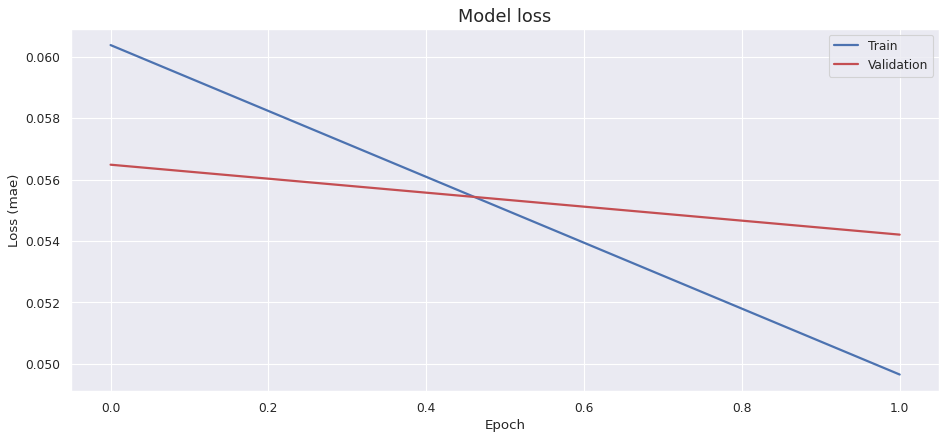

In [ ]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.5)

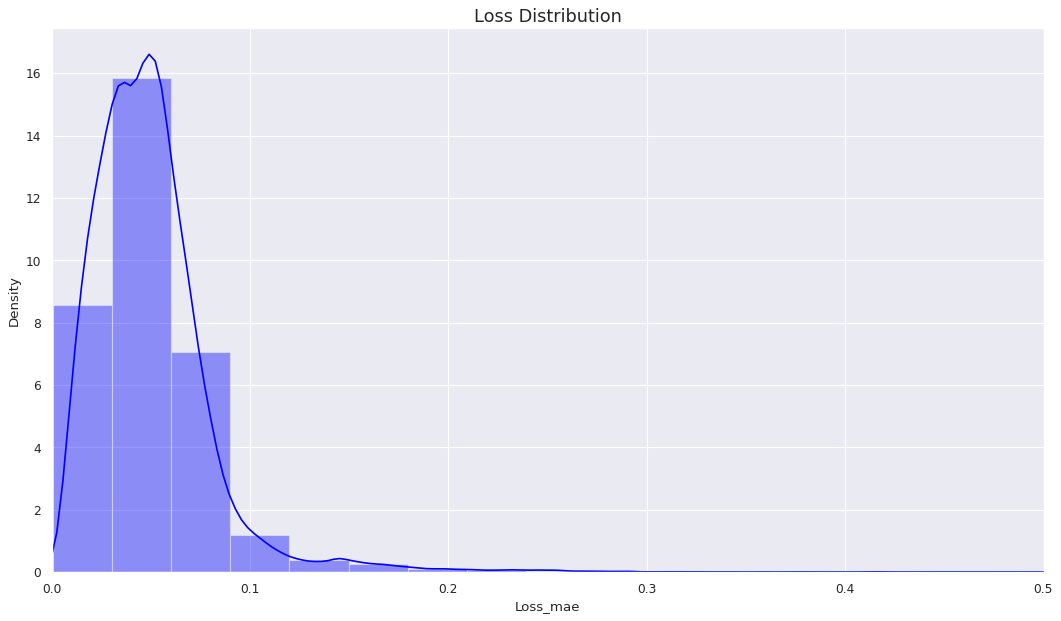

In [ ]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.drop('time',axis=1).columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

In [ ]:
test.head()

,time,x,y,z
60001,30.0005,0.35156,-0.82031,-0.39844
60002,30.0010,0.35938,-0.87500,-0.42188
60003,30.0015,0.28125,-0.75000,-0.35156
60004,30.0020,0.31250,-0.77344,-0.34375
60005,30.0025,0.35938,-0.80469,-0.32812


In [ ]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.drop('time',axis=1).columns)
X_pred.index = test.index



In [ ]:
scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.45
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

df2= test
df2['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
df2.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,time,x,y,z,Anomaly
60001,30.0005,0.35156,-0.82031,-0.39844,False
60002,30.0010,0.35938,-0.87500,-0.42188,False
60003,30.0015,0.28125,-0.75000,-0.35156,False
60004,30.0020,0.31250,-0.77344,-0.34375,False
60005,30.0025,0.35938,-0.80469,-0.32812,False


In [ ]:
test['Anomaly'].value_counts()
import seaborn as sns
anomalies = df2[df2['Anomaly']==True][' y']


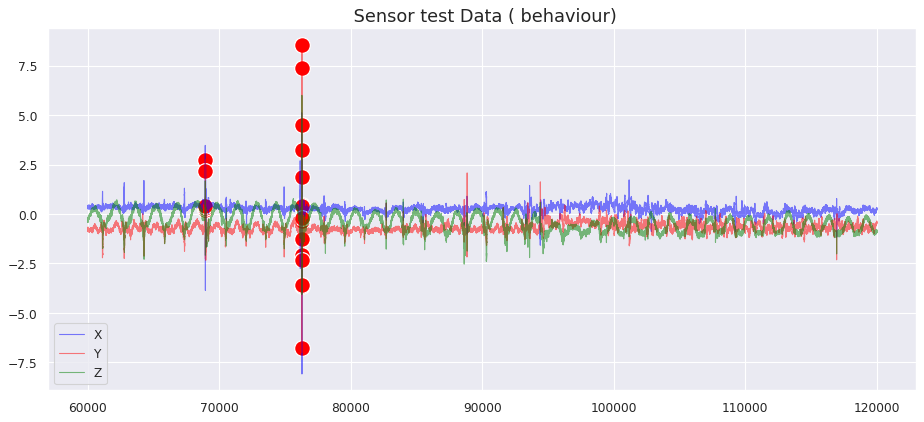

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test[' x'], label='X', color='blue', animated = True, linewidth=1, alpha=0.5)
ax.plot(test[' y'], label='Y', color='red', animated = True, linewidth=1 , alpha=0.5)
ax.plot(test[' z'], label='Z', color='green', animated = True, linewidth=1, alpha=0.5)
#ax.plot(test[test['Anomaly']==True][' y'], label='anomalies', color='pink',marker='*', animated = True)
sns.scatterplot(data= anomalies , x= anomalies.index, y = anomalies.values ,palette='bright',s=200,color='red')

plt.legend(loc='lower left')
ax.set_title(' Sensor test Data ( behaviour)', fontsize=16)
plt.show()

# Trying to use less data
Going to attempt to use the average measurement over 10 seconds

In [ ]:
# Different approach
df = pd.read_csv('./out.csv')  
df.head()

,time,x,y,z
0,0.0000,0.08594,-0.53125,0.57031
1,0.0005,0.09375,-0.50781,0.60938
2,0.0010,0.10938,-0.56250,0.55469
3,0.0015,0.12500,-0.56250,0.61719
4,0.0020,0.14062,-0.61719,0.50781


In [ ]:
means = pd.DataFrame()
for i in range(0,len(df),20):
  row_of_ten = df.iloc[i:i+10].drop('time',axis=1)
  mean_abs = np.array(row_of_ten.abs().mean())
  mean_abs = pd.DataFrame(mean_abs.reshape(1,3))
  mean_abs.index = [df.iloc[i]['time']]
  means = means.append(mean_abs)

In [ ]:
len(means), len(df)

(6000, 120000)

In [ ]:
means.columns = [' x',' y',' z']

In [ ]:
means.head()

,x,y,z
0.00,0.109376,0.547656,0.576564
0.01,0.118750,0.561717,0.624220
0.02,0.050780,0.591407,0.601563
0.03,0.046875,0.536717,0.589844
0.04,0.078906,0.503127,0.712501


In [ ]:
df = means 

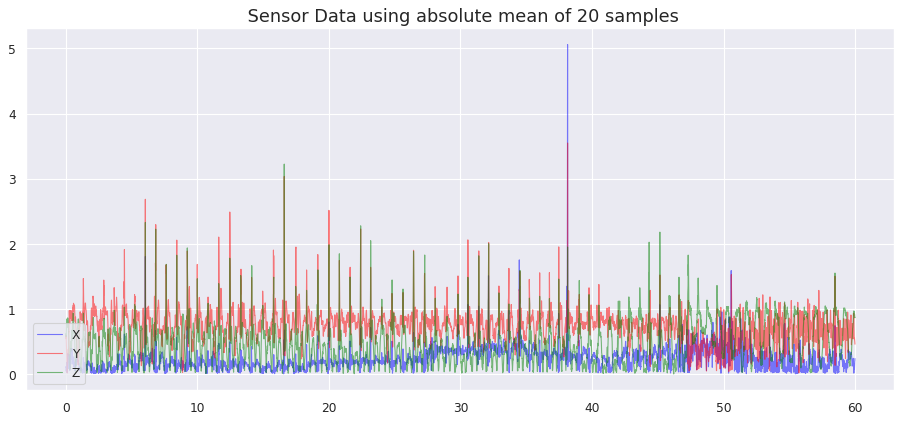

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(df[' x'], label='X', color='blue', animated = True, linewidth=1, alpha=0.5)
ax.plot(df[' y'], label='Y', color='red', animated = True, linewidth=1,alpha=0.5)
ax.plot(df[' z'], label='Z', color='green', animated = True, linewidth=1,alpha=0.5)
plt.legend(loc='lower left')
ax.set_title(' Sensor Data using absolute mean of 20 samples', fontsize=16)
plt.show()

A lot more noise seems to derive from this aproach since just using the absolute value makes use loose a lot of information. Many new "Fake anomalies" seem to pop up. As a result I will refrain from this aproach 

# Naive Anomaly detection attempt
I'm going to try some simple deviation based alrogithms here


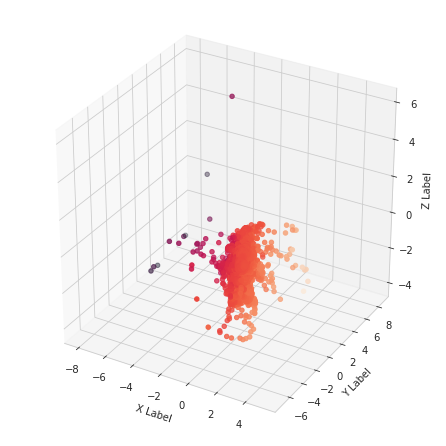

In [ ]:
import re, seaborn as sns, numpy as np, pandas as pd, random
from pylab import *
from matplotlib.pyplot import plot, show, draw, figure, cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


sns.set_style("whitegrid", {'axes.grid' : False})


fig2 = plt.figure(figsize=(6,6))

ax = Axes3D(fig2) # Method 1
# ax = fig.add_subplot(111, projection='3d') # Method 2

x = df['x']
y = df['y']
z = df['z']


ax.scatter(x, y, z, c=x, marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

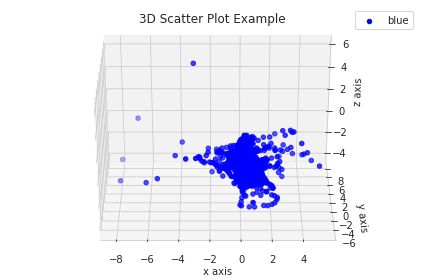

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = df['x']
y = df['y']
z = df['z']



ax.view_init(elev=30, azim=-90)
ax.scatter(x, y, z, c='b', marker='o', label='blue')

ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')
plt.title("3D Scatter Plot Example")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=3)

sns.lineplot(x=df['time'],y=df['x'],  ax=axs[0], color='blue', label='x')
sns.lineplot(x=df['time'],y=df['y'],  ax=axs[1], color='red' ,   label='y')
sns.lineplot(x=df['time'],y=df['z'],  ax=axs[2], color ='green', label='z')
plt.legend() 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# CALCULATE MEAN DEVIATION

In [ ]:
means= pd.DataFrame()
means['x'] = df['x']-df['x'].mean()
means['y'] = df['y']-df['y'].mean()
means['z'] = df['z']-df['z'].mean()

In [ ]:
df.groupby("x").var().reset_index()

vars= pd.DataFrame()
vars['x'] = df.groupby("x").var().reset_index()['x']
vars['y'] = df.groupby("y").var().reset_index()['y']
vars['z'] = df.groupby("z").var().reset_index()['z']

In [ ]:
vars

,x,y,z
0,-8.08594,-7.00781,-4.07031
1,-8.06250,-6.77344,-3.69531
2,-6.95312,-5.35156,-3.63281
3,-6.21094,-4.80469,-3.55469
4,-5.43750,-3.96875,-3.54688
...,...,...,...
418,4.04688,0.42188,0.62500
419,4.17188,0.42969,0.63281
420,4.35938,0.43750,0.64062
421,4.64062,0.44531,0.64844


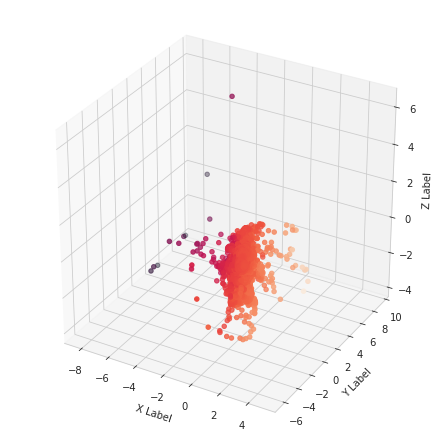

In [ ]:
fig2 = plt.figure(figsize=(6,6))

ax = Axes3D(fig2) # Method 1
# ax = fig.add_subplot(111, projection='3d') # Method 2

x = means['x']
y = means['y']
z = means['z']


ax.scatter(x, y, z, c=x, marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

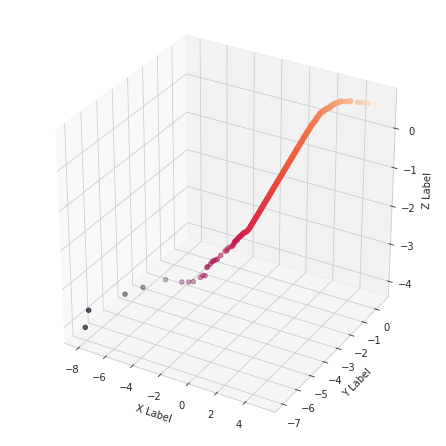

In [ ]:
fig2 = plt.figure(figsize=(6,6))

ax = Axes3D(fig2) # Method 1
# ax = fig.add_subplot(111, projection='3d') # Method 2

x = vars['x']
y = vars['y']
z = vars['z']


ax.scatter(x, y, z, c=x, marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

Acknoledgements:
Based on :
 https://github.com/BLarzalere/LSTM-Autoencoder-for-Anomaly-Detection
https://www.youtube.com/watch?v=6S2v7G-OupA&t=767s

In [ ]:
catfish_sales = df.asfreq(pd.infer_freq(df.index))


In [ ]:
df2 = df.set_index('time')

In [ ]:
df2.diff()[1:]

,x,y,z
time,,,
1.0000,-0.03906,0.02344,0.06250
1.0005,-0.04688,0.00000,0.00781
1.0010,0.04688,-0.02344,-0.09375
1.0015,-0.03125,-0.01562,-0.00781
1.0020,0.01563,-0.01563,-0.01562
...,...,...,...
59.9975,-0.00782,-0.00781,0.10156
59.9980,-0.01562,0.03124,-0.04688
59.9985,0.07031,-0.02343,-0.03906


In [ ]:
# Getting rid of the trend
first_diff = df2.diff()[1:]


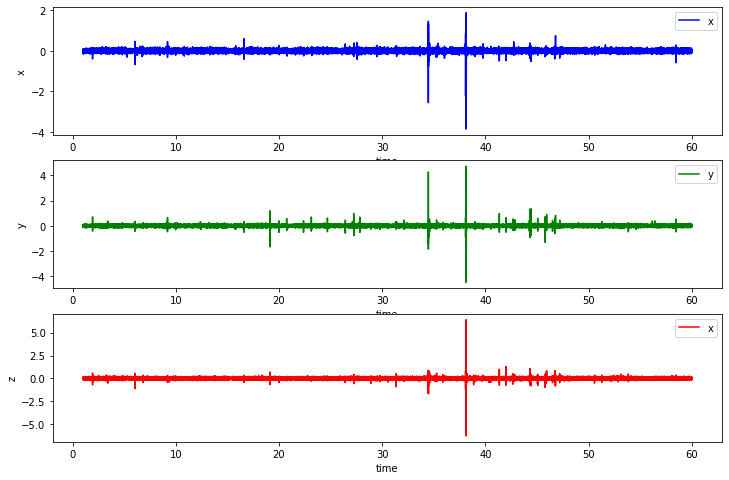

In [ ]:
fig, axs = plt.subplots(nrows=3, figsize=(12,8))

sns.lineplot(data=first_diff['x'],  ax=axs[0], color='blue', label='x')
sns.lineplot(data=first_diff['y'],  ax=axs[1], color='green', label='y')
sns.lineplot(data=first_diff['z'],  ax=axs[2], color='red', label='x')




In [ ]:
# Select train test split, I'm gonna split it where I seem fit 
train, test = df.loc[df['time'] <= 30] , df.loc[df['time'] > 30]

print("Start date is: ", df['time'].min())
print("End date is: ", df['time'].max())

Start date is:  0.0
End date is:  59.9995


In [ ]:
rolling_deviations = pd.Series(dtype=float, index = df2.index)


In [ ]:
rolling_deviations.head()

time
0.0000   NaN
0.0005   NaN
0.0010   NaN
0.0015   NaN
0.0020   NaN
dtype: float64

In [ ]:
from tqdm import tqdm
df.std()


time    17.320580
x        0.186216
y        0.258978
z        0.519076
dtype: float64

In [ ]:
for date in tqdm(rolling_deviations.index):
    #get the window ending at this data point
    window = df.loc[:date]
    
    #get the deviation within this window
    rolling_deviations.loc[date] = window.std()

 78%|███████▊  | 93585/120000 [21:46<06:08, 71.63it/s]


KeyboardInterrupt: ignored

In [ ]:
rolling_deviations.head()

time
0.0000   NaN
0.0005   NaN
0.0010   NaN
0.0015   NaN
0.0020   NaN
dtype: float64